In [111]:
import sys
sys.path.insert(0, "../")

In [112]:
from utils.inpca import reduce_rep
import numpy as np
import matplotlib.pyplot as plt
from utils.data import Cifar100Dataset
import torch

In [209]:
def plot_inpca(reduced, num_models, labels = None, elevation=None, azimuth=None, plot_true_probs = False, save_path = None):
    if labels == None:
        labels = [f"Seed {i}" for i in range(num_models)]


    # define new colors that are easier to tell apart
    cols = ['#336699', '#993333', '#999933', '#666699']

    fig = plt.figure(figsize=(15, 15))  # set figure size
    ax = plt.axes(projection='3d')

    if elevation != None and azimuth != None:
        ax.view_init(elev=elevation, azim=azimuth)  # set viewing angle

    # plot the original points
    for i in range(num_models):
        if (not plot_true_probs):
            ax.scatter3D(reduced["inpca"][i, :, 0], reduced["inpca"][i, :, 1], reduced["inpca"][i, :, 2], c=cols[i], label=labels[i], s=25)  # reduce point size using the 's' parameter
        else:
            include_elts = np.mod(np.arange(reduced["inpca"].shape[1]), reduced["inpca"].shape[1] // 4) != (reduced["inpca"].shape[1] // 4 - 1)
            include_elts = np.argwhere(include_elts).flatten()
            ax.plot3D(reduced["inpca"][i, -1, 0], reduced["inpca"][i,  -1, 1] ,reduced["inpca"][i,  -1, 2], marker='o', markersize=5, color='k', alpha=1)
            ax.text(reduced["inpca"][i, -1, 0]+ 0.02, reduced["inpca"][i, -1, 1] + 0.01, reduced["inpca"][i, -1, 2] + 0.005, s=r'$P^*$', fontsize=20)
            ax.scatter3D(reduced["inpca"][i, include_elts, 0], reduced["inpca"][i, include_elts, 1], reduced["inpca"][i, include_elts, 2], c=cols[i], label=labels[i], s=25)
            

    # label the axes as PC1, PC2, PC3
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    

    ax.legend()  # show legend
    ax.grid(False)  # remove grid lines

    if (save_path is not None):
        plt.savefig(save_path + ".png", bbox_inches='tight')


def get_probs(fdir, model_name, task_name):
    # iterate over seeds 0, 10, 20, 30 then load the probs for each seed and stack along the first axis
    for seed in range(0, 40, 10):
        # load pretraining
        pretraining_probs = np.load(f"{fdir}/pretraining/{task_name}/{model_name}_seed_{seed}/probs.npy")

        # load finetuning
        finetuning_probs = np.load(f"{fdir}/finetuning/{task_name}/{model_name}_seed_{seed}/probs.npy")


        # stack each along a new axis -- the first axis, to make all_pretraining and all_finetuning
        # have shape (num_seeds, num_examples, num_classes)
        if seed == 0:
            all_pretraining = pretraining_probs[np.newaxis, ...]
            all_finetuning = finetuning_probs[np.newaxis, ...]
        else:
            all_pretraining = np.concatenate((all_pretraining, pretraining_probs[np.newaxis, ...]), axis=0)
            all_finetuning = np.concatenate((all_finetuning, finetuning_probs[np.newaxis, ...]), axis=0)

    return all_pretraining, all_finetuning


## Task 0, 1, 2, 3, 4

In [114]:
task_name = "0_1_2_3_4"
task_labs = [int(i) for i in task_name.split("_")]

dataset = Cifar100Dataset(task_labs, permute= False)
trainloader, testloader = dataset.fetch_data_loaders(bs = 256, shuf = False)

Files already downloaded and verified
Files already downloaded and verified


In [115]:
train_data = torch.cat([batch[1] for batch in trainloader])
# create a one-hot encoded tensor from the concatenated tensor
all_labels = torch.nn.functional.one_hot(train_data, num_classes=5).numpy()

# stack four copies of all labels to make a new axis
all_labels = np.stack([all_labels for _ in range(4)], axis=0)
# insert a new axis in the second position
all_labels = np.expand_dims(all_labels, axis=1)

### SimCLR

In [117]:
fdir="../probs/SimCLR"
model_name = "cifar10_resnet18_lr_0.05_decay_0.0001_bsz_256_temp_0.07_cosine"


In [118]:
# reduce representation
all_pretraining_simclr, all_finetuning_simclr = get_probs(fdir, model_name, task_name)
all_finetuning_simclr_with_true = np.concatenate((all_finetuning_simclr, all_labels), axis=1)

In [119]:

pretraining_reduced = reduce_rep(all_pretraining_simclr, inpca=True, dynamic_shape=False)
finetuning_reduced = reduce_rep(all_finetuning_simclr, inpca=True, dynamic_shape=False)


0
500
1000
1500
2000
0
500
1000
1500
2000


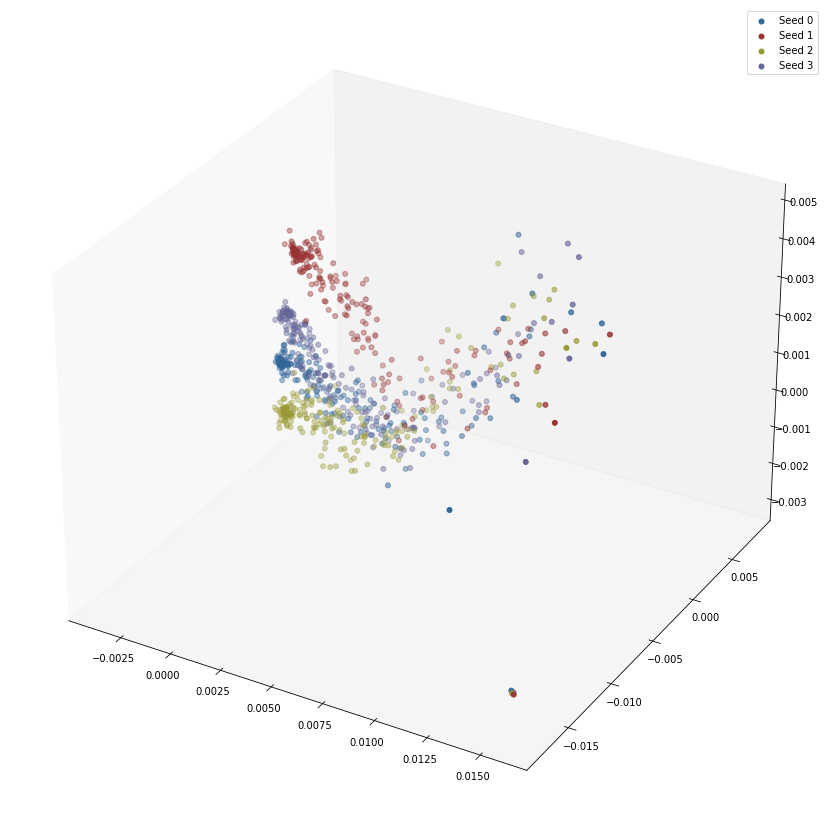

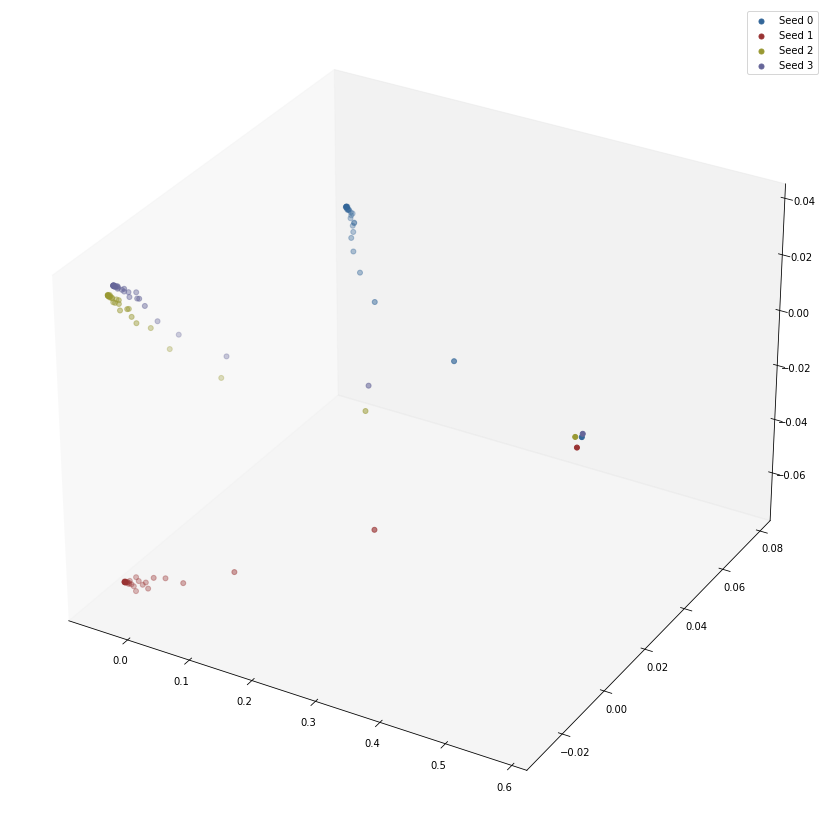

In [120]:
# plot inpca
plot_inpca(pretraining_reduced, 4)
plot_inpca(finetuning_reduced, 4) 

### SupCon

In [121]:
fdir="../probs/SupCon"
model_name = "cifar10_resnet18_lr_0.05_decay_0.0001_bsz_256_temp_0.07_cosine"


In [122]:
# reduce representation
all_pretraining_supcon, all_finetuning_supcon = get_probs(fdir, model_name, task_name)
all_finetuning_supcon_with_true = np.concatenate((all_finetuning_supcon, all_labels), axis=1)
pretraining_reduced = reduce_rep(all_pretraining_supcon, inpca=True, dynamic_shape=False)
finetuning_reduced = reduce_rep(all_finetuning_supcon, inpca=True, dynamic_shape=False)


0
500
1000
1500
2000
0
500
1000
1500
2000


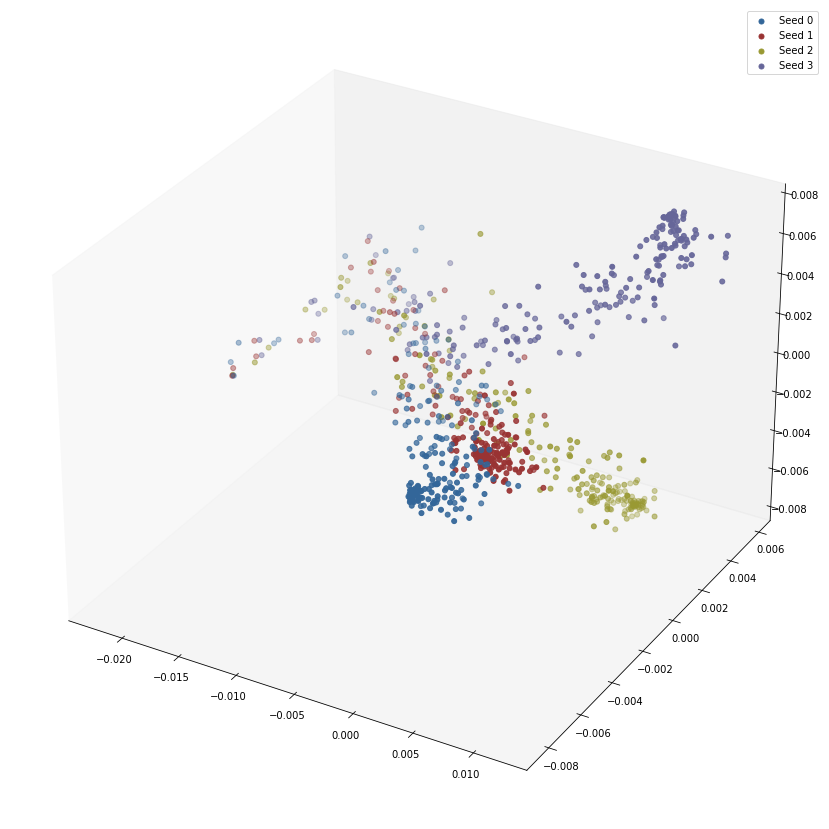

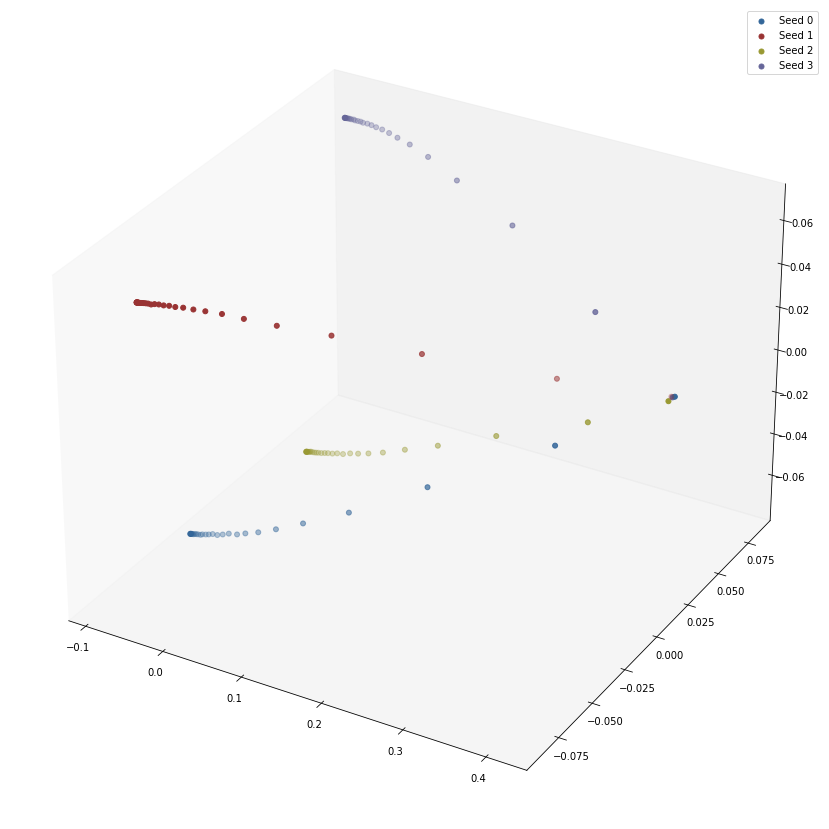

In [123]:
# plot inpca
plot_inpca(pretraining_reduced, 4)
plot_inpca(finetuning_reduced, 4)

### SupCE

In [124]:
fdir="../probs/SupCE"
model_name = "cifar10_resnet18_lr_0.2_decay_0.0001_bsz_256_cosine"


In [133]:
# reduce representation
all_pretraining_supce, all_finetuning_supce = get_probs(fdir, model_name, task_name)
all_finetuning_supce_with_true = np.concatenate((all_finetuning_supce, all_labels), axis=1)
pretraining_reduced_supce = reduce_rep(all_pretraining_supce, inpca=True, dynamic_shape=False)
finetuning_reduced_supce = reduce_rep(all_finetuning_supce, inpca=True, dynamic_shape=False)


0
500
1000
1500
2000
0
500
1000
1500
2000


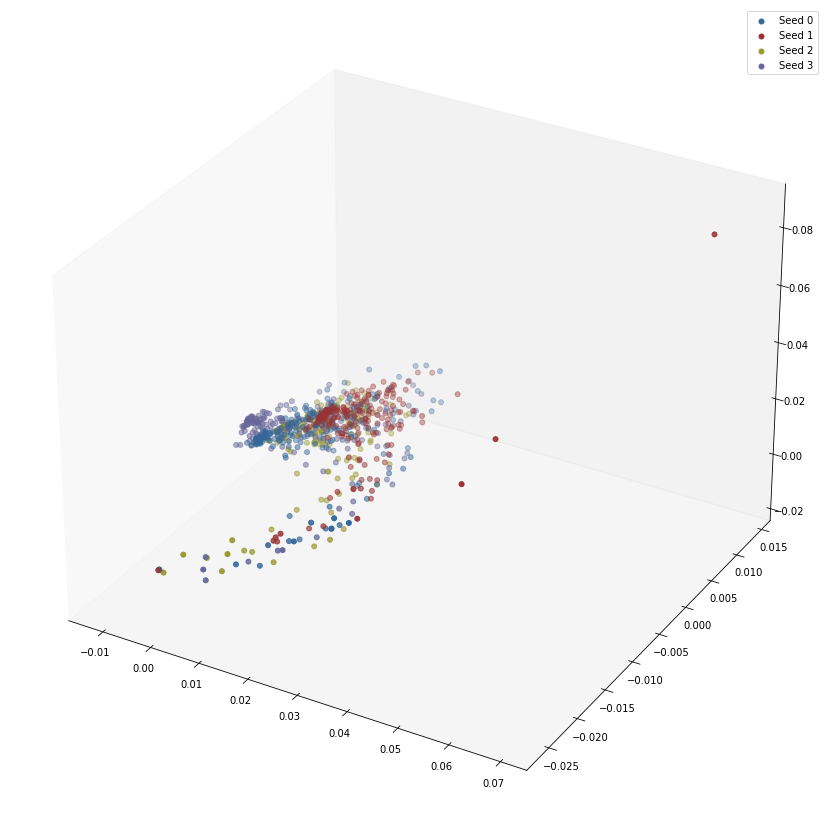

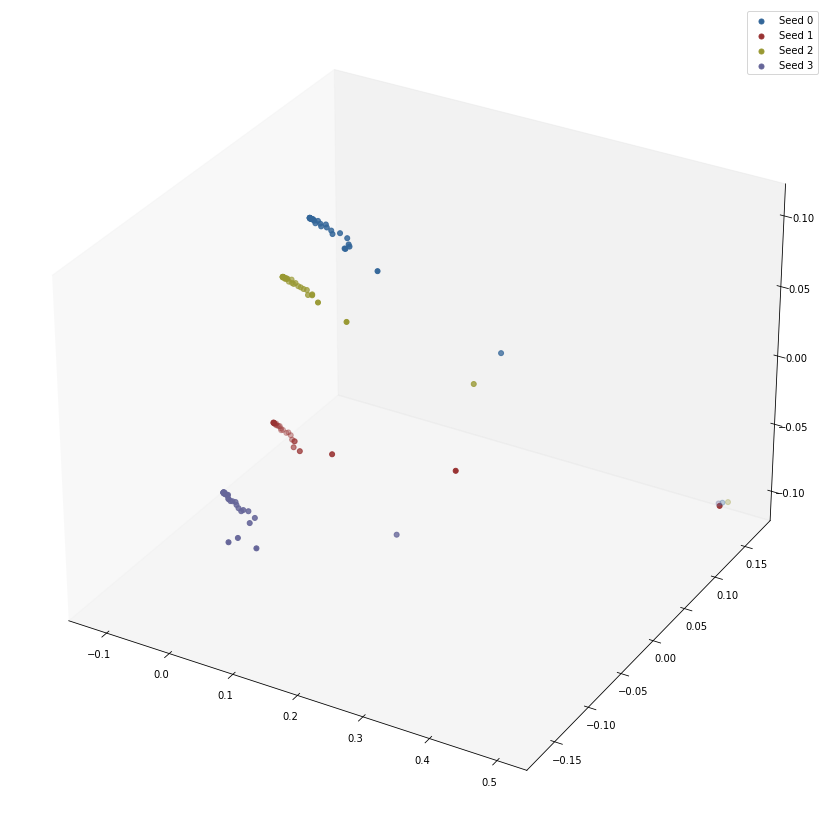

In [147]:
# plot inpca
plot_inpca(pretraining_reduced_supce, 4)
plot_inpca(finetuning_reduced_supce, 4)

In [148]:
finetuning_reduced_supce["inpca"][0, 1, :]

array([ 0.26187825,  0.04460442,  0.02690197,  0.02625448, -0.08235632])

### Comparing All

In [137]:
all_pretraining_supce_all_seeds = np.concatenate(all_pretraining_supce, axis=0)
all_pretraining_simclr_all_seeds = np.concatenate(all_pretraining_simclr, axis=0)
all_pretraining_supcon_all_seeds = np.concatenate(all_pretraining_supcon, axis=0)

# stack all pretraining probs along the first axis
all_pretraining = np.stack((all_pretraining_supce_all_seeds, all_pretraining_simclr_all_seeds, all_pretraining_supcon_all_seeds), axis=0)


# Do the same for finetuning

all_finetuning_supce_all_seeds = np.concatenate(all_finetuning_supce_with_true, axis=0)
all_finetuning_simclr_all_seeds = np.concatenate(all_finetuning_simclr_with_true, axis=0)
all_finetuning_supcon_all_seeds = np.concatenate(all_finetuning_supcon_with_true, axis=0)

# stack all finetuning probs along the first axis
all_finetuning = np.stack((all_finetuning_supce_all_seeds, all_finetuning_simclr_all_seeds, all_finetuning_supcon_all_seeds), axis=0)

In [138]:
# reduce representation
pretraining_reduced = reduce_rep(all_pretraining, inpca=True, dynamic_shape=False) 
finetuning_reduced = reduce_rep(all_finetuning, inpca=True, dynamic_shape=False)                                                     

0
500
1000
1500
2000


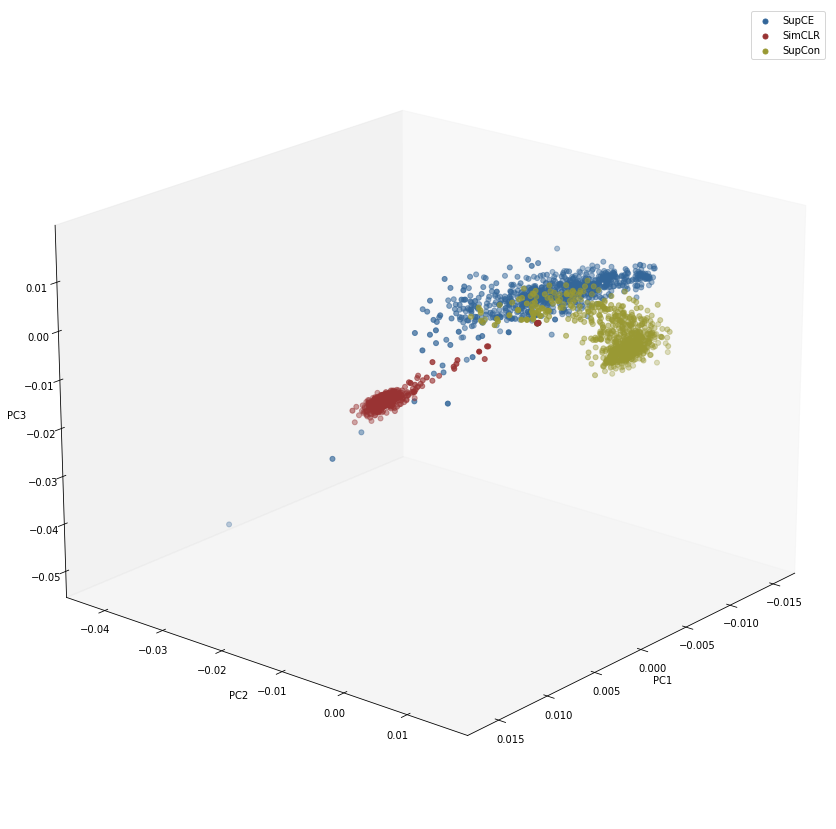

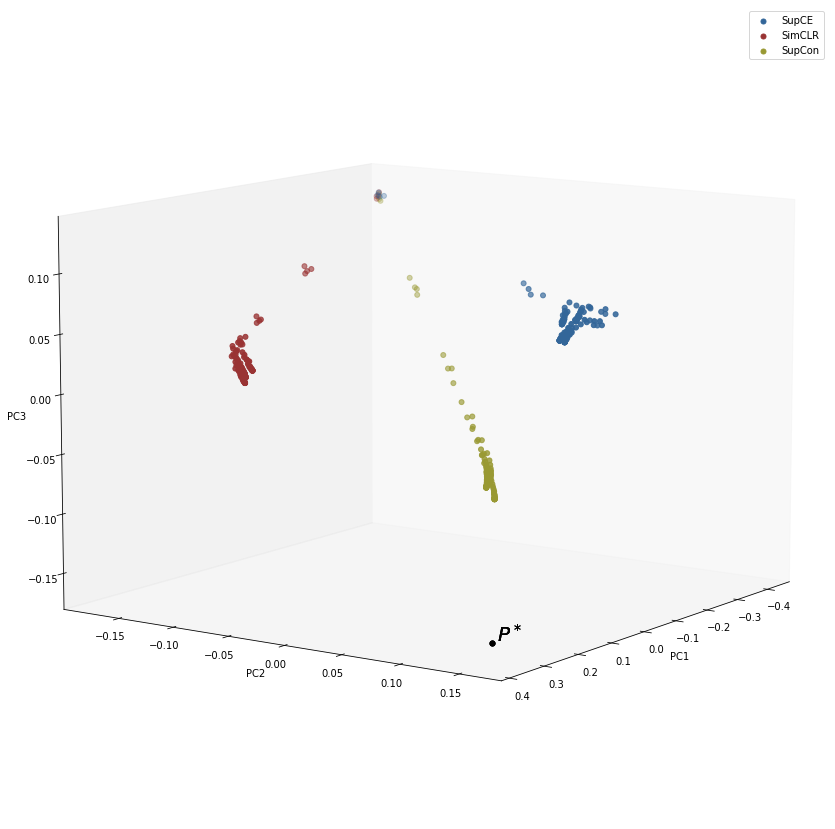

In [233]:
# plot inpca
plot_inpca(pretraining_reduced, 3, labels = ["SupCE", "SimCLR", "SupCon"], azimuth=40, elevation=20)
plot_inpca(finetuning_reduced, 3, labels = ["SupCE", "SimCLR", "SupCon"], azimuth = 35, elevation=10, plot_true_probs = True)

In [188]:
finetuning_reduced["inpca"].shape

(3, 128, 5)

In [192]:
include_elts

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False]

In [193]:
include_elts = np.mod(np.arange(finetuning_reduced["inpca"].shape[1]), finetuning_reduced["inpca"].shape[1] // 4) != (finetuning_reduced["inpca"].shape[1] // 4 - 1)


array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
       [ 72],
      

(124, 5)